In [1]:
# Explore some simple models using a simple train, validation, and test split. 
# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [45]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline)
from sklearn.linear_model import LinearRegression

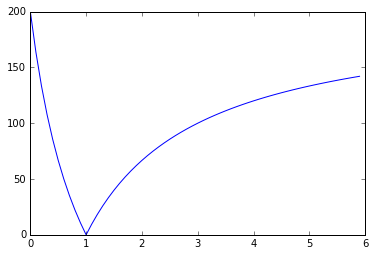

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [10]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [11]:
def windowsAvgs(X, windowT = 100):
    Xheight, Xwidth = X.shape
    windows = np.mean(X[:, -windowT:], axis = 1).reshape(-1,1)
    for start in range(2*windowT, Xwidth, windowT):
        newcol = np.mean(X[:, -start: -start + windowT], axis = 1).reshape(-1,1)
        np.hstack((windows, newcol))
    return windows

def windowsLinear(X, windowT = 100):
    Xheight, Xwidth = X.shape
    linearPart = np.arange(windowT)
    windows = np.dot(X[:,-windowT:], linearPart).reshape(-1,1)
    for start in range(2 * windowT, Xwidth, windowT):
        newcol = np.dot(X[:, -start: -start + windowT], linearPart).reshape(-1,1)
        np.hstack((windows, newcol))
    return windows

def windowsPower(X, power = 2, windowT = 100):
    Xheight, Xwidth = X.shape
    powerVals = np.arange(windowT)**power
    windows = np.dot(X[:,-windowT:], powerVals).reshape(-1,1)
    for start in range(2 * windowT, Xwidth, windowT):
        newcol = np.dot(X[:, -start: -start + windowT], powerVals).reshape(-1,1)
        np.hstack((windows, newcol))
    return windows

def windowsMultiPower(X, power = 2, windowT = 100):
    Xheight, Xwidth = X.shape
    result = np.empty((Xheight, 0))
    for curPower in range(power + 1):
        newArray = windowsPower(X, curPower, windowT)
        result = np.hstack((result, newArray))
    return result

def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

In [23]:
# Let's look at a simple model based on a linear fit of windows averages. We will look at validating the smape scores
# for varying window size.

model = Pipeline([('pre', FunctionTransformer(windowsAvgs)),
                  ('poly', PolynomialFeatures(2)),
                  ('linear', LinearRegression()) ])
model.set_params(pre__kw_args = {'windowT' : 64})
model.get_params()

{'linear': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'linear__copy_X': True,
 'linear__fit_intercept': True,
 'linear__n_jobs': 1,
 'linear__normalize': False,
 'poly': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
 'poly__degree': 2,
 'poly__include_bias': True,
 'poly__interaction_only': False,
 'pre': FunctionTransformer(accept_sparse=False,
           func=<function windowsAvgs at 0x000002184C4DEC80>,
           inv_kw_args=None, inverse_func=None, kw_args={'windowT': 64},
           pass_y=False, validate=True),
 'pre__accept_sparse': False,
 'pre__func': <function __main__.windowsAvgs>,
 'pre__inv_kw_args': None,
 'pre__inverse_func': None,
 'pre__kw_args': {'windowT': 64},
 'pre__pass_y': False,
 'pre__validate': True,
 'steps': [('pre', FunctionTransformer(accept_sparse=False,
             func=<function windowsAvgs at 0x000002184C4DEC80>,
             inv_kw_args=None, inverse_func=None, kw_args={'windowT': 64},
 

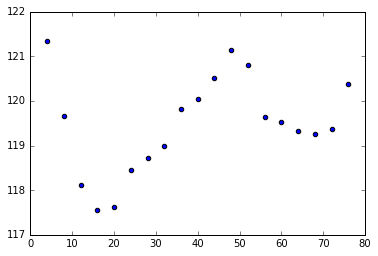

In [27]:
# Now do the validations.

step = 4
nStep = 20
windowSizes = range(step, nStep * step, step)
scores = []

for size in windowSizes:
    model.set_params(pre__kw_args = {'windowT' : size})
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    scores.append(smape(Y_valid, Y_predict))
    
plt.scatter(windowSizes, scores)
plt.show()

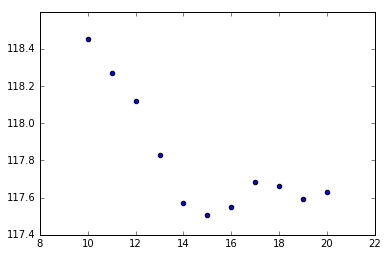

In [28]:
# Do a finer search of window size

start = 10
stop = 21
windowSizes = range(start, stop)
scores = []

for size in windowSizes:
    model.set_params(pre__kw_args = {'windowT' : size})
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    scores.append(smape(Y_valid, Y_predict))
    
plt.scatter(windowSizes, scores)
plt.show()

In [29]:
# Let's do a test of optimal validation value.

model.set_params(pre__kw_args = {'windowT' : 15})
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('smape = ', smape(Y_test, Y_predict))

smape =  111.528317348


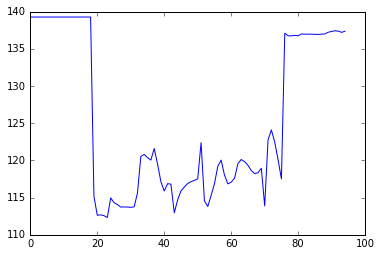

In [36]:
# Now let's try searching over window size and powers for polynomial features.

step = 4
nStep = 20
maxPower = 5

powers = range(maxPower)
windowSizes = range(step, nStep * step, step)
scores = []

hyperparams = [(x, y) for x in powers for y in windowSizes]

bestScore = 1000
bestparams = None

for power, size in hyperparams:
    model.set_params(pre__kw_args = {'windowT' : size},
                     poly__degree = power)
    model.fit(X_test, Y_test)
    Y_predict = model.predict(X_valid)
    thisScore = smape(Y_valid, Y_predict)
    scores.append(thisScore)
    if thisScore < bestScore:
        bestScore = thisScore
        bestparams = (power, size)
    
plt.plot(scores)
plt.show()

print('Best score = ', bestScore, '\tBest Params = ', bestparams)

In [37]:
print('Best score = ', bestScore, '\tBest Params = ', bestparams)

Best score =  112.320364161 	Best Params =  (1, 20)


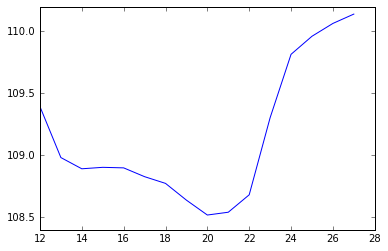

Best Score =  108.519168489 	Best Params =  (1, 20)


In [40]:
# Now let's do a finer search on window size for best params.

width = 8
degree, centerSize = bestparams

windowSizes = range(centerSize - width, centerSize + width)

scores = []
bestScore = 1000
bestParams = None

for size in windowSizes:
    model.set_params(poly__degree = degree,
                     pre__kw_args = {'windowT' : size})
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_valid)
    thisScore = smape(Y_predict, Y_valid)
    scores.append(thisScore)
    if thisScore < bestScore:
        bestScore = thisScore
        bestParams = (degree, size)
        
plt.plot(windowSizes, scores)
plt.show()
print('Best Score = ', bestScore, '\tBest Params = ', bestParams)

In [44]:
# Now let's do a test.

degree, windowSize = bestParams
model.set_params(pre__kw_args = {'windowT' : windowSize},
                 poly__degree = degree)
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('smape = ', smape(Y_predict, Y_test))

smape =  111.838374555


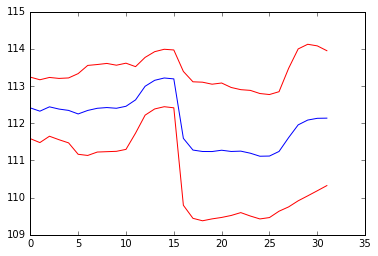

Best Score =  111.111938333 	Best Params =  (2, 20)


In [69]:
# Now let's try a finer search of cross validation score.

# Now let's do a finer search on window size for best params.

width = 8
degree, centerSize = bestparams

windowSizes = np.arange(centerSize - width, centerSize + width, 1)

scores = np.empty(0)
scores_std = np.empty(0)
bestScore = 1000
bestParams = None

for degree in [1,2]:
    for size in windowSizes:
        model.set_params(poly__degree = degree,
                         pre__kw_args = {'windowT' : size})
        thisScore = -cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
        scores_std = np.append(scores_std, np.std(thisScore))
        thisScore = np.mean(thisScore)
        scores = np.append(scores, thisScore)
        if thisScore < bestScore:
            bestScore = thisScore
            bestParams = (degree, size)
        
plt.plot(scores)
plt.plot(scores - scores_std, color = 'red')
plt.plot(scores + scores_std, color = 'red')
plt.show()
print('Best Score = ', bestScore, '\tBest Params = ', bestParams)

In [70]:
# Now let's do a test.

degree, windowSize = bestParams
model.set_params(pre__kw_args = {'windowT' : windowSize},
                 poly__degree = degree)
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('smape = ', smape(Y_predict, Y_test))

smape =  111.206137698
